## The function to calculate the Pearson correlation coefficient

In [2]:
import numpy as np 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec
import scipy.ndimage as ndimage
from matplotlib.ticker import AutoMinorLocator, FormatStrFormatter
import matplotlib.mlab as mlab
from matplotlib import cm
from scipy.interpolate import interp1d
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['axes.linewidth'] = 2

mpl.rcParams['font.weight'] = 'bold'
mpl.rcParams['axes.labelweight'] = 'bold'

plt.rc('text', usetex=True) ## this line is necessary to use the correct fonts 
plt.rc('font', family='serif') # this line is necessary to use the correct font


# This function makes the plots pretty 
def plot_prop(f1,ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left') 
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['left'].set_position(('axes', -0.02))
    ax.spines['bottom'].set_position(('axes', -0.02))
    ax.xaxis.set_minor_locator(AutoMinorLocator(1))
    ax.yaxis.set_minor_locator(AutoMinorLocator(1))

    # x and y tickers
    plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%g'))
    plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))
    plt.tick_params(direction='out',which='major', length=10,width=1.5,colors='k',labelsize=f1)
    plt.tick_params(direction='out',which='minor',length=4,width=1, color='k')
    
    return;


In [ ]:
"""
The function takes the adjacency matrix and returns the corresponding Graphs's Pearson's correlation coefficient. 
If the correlation > 0, the network is 'assortative' and if it is < 0, the network is 'disassortative'.
This function uses networkx library in Python.
"""

import networkx as nx

def PearsonCorr(Adj): # Adj: rows-> postsynaptic neurons and columns-> presynaptic neurons
    Adj1 = Adj.transpose()
    G = nx.from_numpy_array(Adj1, create_using=nx.DiGraph)
    corr00 = nx.degree_pearson_correlation_coefficient(G,x='in',y='in')
    corr01 = nx.degree_pearson_correlation_coefficient(G,x='in',y='out')
    corr10 = nx.degree_pearson_correlation_coefficient(G,x='out',y='in')
    corr11 = nx.degree_pearson_correlation_coefficient(G,x='out',y='out')
    corr = np.array([corr00, corr01, corr10, corr11]).reshape(2,2)
    return corr


In [3]:
"""
The function takes the adjacency matrix, degress-type of the presynaptic neurons and the degree-type of the 
postsynaptic neurons, and returns the Pearson's correlation coefficient. 
If the correlation > 0, the network is 'assortative' and if it is < 0, the network is 'disassortative'.
This function DOES NOT use networkx library in Python. It implements Eq.18 from our paper: 
"Synaptic reorganization of synchronized neuronal networks with synaptic weight and structural plasticity"
"""

def PearsonCorrelation(A, deg_type_pre, deg_type_post): # A- adjacency matrix; degree types- 'in' or 'out'
    N = A.shape[0]
    degrees = np.zeros([2,N]) # row 0 -> in degrees; row 1 -> out degrees    
    degrees[0] = np.sum(A,axis=1)/(N-1) # in degrees
    degrees[1] = np.sum(A,axis=0)/(N-1) # out degrees
    
    # setting the row index for 'degrees' based on the degree type passed to the function
    if deg_type_pre == 'in':
        deg_type_pre = 0
    else:
        deg_type_pre = 1
    if deg_type_post == 'in':
        deg_type_post = 0
    else:
        deg_type_post = 1
    
    # calculating the average degrees of pre- and post- synaptic neurons
    sum_pre = 0; sum_post = 0; ncon = 0
    for i in range(N):
        for j in range(N):
            if A[i,j] != 0: # i -> postsyn index; j -> presyn index
                sum_pre += degrees[deg_type_pre,j]
                sum_post += degrees[deg_type_post,i]
                ncon += 1
    mean_pre = sum_pre/ncon
    mean_post = sum_post/ncon
    
    # calculating the standard deviation of degrees and the Pearson correlation
    sum_pre = 0; sum_post = 0; sumr = 0
    for i in range(N):
        for j in range(N):
            if A[i,j] != 0:
                sum_pre += (degrees[deg_type_pre,j]-mean_pre)**2
                sum_post += (degrees[deg_type_post,i]-mean_post)**2
                sumr += (degrees[deg_type_pre,j]-mean_pre)*(degrees[deg_type_post,i]-mean_post)
    sigma_pre = (sum_pre/ncon)**0.5
    sigma_post = (sum_post/ncon)**0.5
    PearsonCorr = sumr/ncon/sigma_pre/sigma_post
                
    return PearsonCorr

## Example

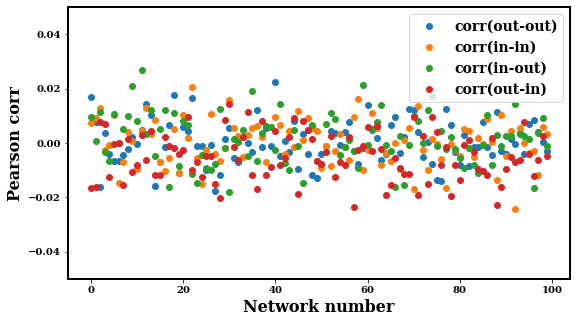

0.00024281714229431515 0.00016030048840811654 0.0012615802001944012 -0.004847206575274169


In [4]:
# pearson correlation for random networks

np.random.seed(1000)
n_nets = 100
N = 400 # network size 
corr_vals = np.zeros([4,n_nets]) # 0- in-in; 1- in-out; 2- out-in; 3- out-out

for i in range(n_nets):
    A = np.zeros([N,N])
    rnd = np.random.uniform(0,1,size=[N,N])
    A[np.where(rnd < 0.075)] = 1 # random adjacency matrix
    
    corr_vals[0,i] = PearsonCorrelation(A,'in','in')
    corr_vals[1,i] = PearsonCorrelation(A,'in','out')
    corr_vals[2,i] = PearsonCorrelation(A,'out','in')
    corr_vals[3,i] = PearsonCorrelation(A,'out','out')
    
plt.figure(figsize=(9,5))
plt.plot(np.arange(0,n_nets),corr_vals[3],label='corr(out-out)',ls='',marker='o',ms=6)
plt.plot(np.arange(0,n_nets),corr_vals[0],label='corr(in-in)',ls='',marker='o',ms=6)
plt.plot(np.arange(0,n_nets),corr_vals[1],label='corr(in-out)',ls='',marker='o',ms=6)
plt.plot(np.arange(0,n_nets),corr_vals[2],label='corr(out-in)',ls='',marker='o',ms=6)
plt.legend(fontsize=14)
plt.ylim(-0.05,0.05)
plt.xlabel('Network number',fontsize=16)
plt.ylabel('Pearson corr',fontsize=16)
plt.show()    

print(np.mean(corr_vals[3]),np.mean(corr_vals[0]),np.mean(corr_vals[1]),np.mean(corr_vals[2]))